In [1]:
import fenics as fn
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
#
from time import time

Given the following PDE:
$$-(a(x)u'(x))' = f(x), \quad x \in (0,1)$$
$$u(0) = u(1) = 0,$$
we want to recover $a(x)$ from observation $\{x_1,x_2,\dots,x_{N_s}\}\times\{u_1,u_2,\dots,u_{N_s}\}\subset \mathbb{R}^2$, by approximating $a$ with a single-hidden-layer neural network $a_{nn}$.

In [2]:
import sys
print('Python version:',sys.version)
'''
Python version: 3.8.13 (default, Oct 21 2022, 23:50:54) 
[GCC 11.2.0]
'''
None

Python version: 3.8.13 (default, Oct 21 2022, 23:50:54) 
[GCC 11.2.0]


In [3]:
np.__version__
# '1.21.5'

'1.21.5'

In [4]:
import scipy
scipy.__version__
# '1.7.3'

'1.7.3'

In [5]:
# training set length
Ns = 22

**Data generation**

In [6]:
a_unknown = fn.Expression('2.*pow(x[0],3) - 3.*pow(x[0],2) + x[0] + .5',degree=3)

**FE setting**

In [7]:
#
Ne = 64
#
mesh = fn.IntervalMesh(Ne, 0,1)
#
Uh = fn.FunctionSpace(mesh,'CG',1)
#
u0 = 0.0
# RHS
f = fn.Expression('pi*sin(pi*x[0])',degree=2)
#
bc = fn.DirichletBC(Uh,u0,'on_boundary')
#
wh, vh = fn.TrialFunction(Uh), fn.TestFunction(Uh)
#
bilinear_form = a_unknown*fn.dot(fn.grad(wh),fn.grad(vh))*(fn.dx)
linear_rhs = f*vh*(fn.dx)
#
uh_sol = fn.Function(Uh)
fn.solve(bilinear_form == linear_rhs, uh_sol, bc)

Solving linear variational problem.


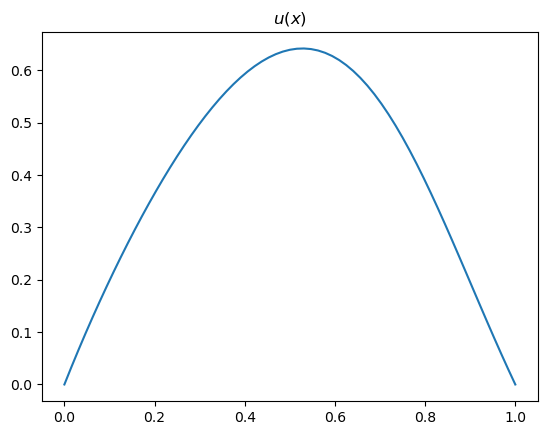

In [8]:
fn.plot(uh_sol)
plt.title(r'$u(x)$')
plt.show()

**Training set generation**

In [9]:
x_train = np.linspace(0,1,Ns)
print(x_train)
#
y_train = np.zeros(x_train.shape)
for i in range(x_train.shape[0]):
    y_train[i] = uh_sol(x_train[i])

[0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048 0.52380952
 0.57142857 0.61904762 0.66666667 0.71428571 0.76190476 0.80952381
 0.85714286 0.9047619  0.95238095 1.        ]


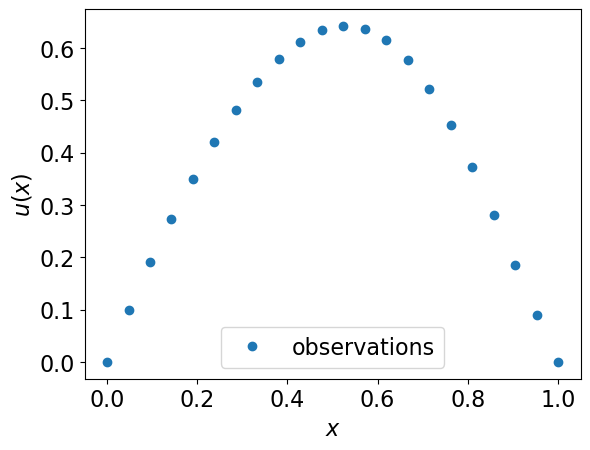

In [10]:
plt.plot(x_train,y_train,
         linestyle='',
         marker='o',
         linewidth=2.0,
         label='observations')
plt.ylabel(r'$u(x)$',fontsize=16) # "r" means raw sequence
plt.yticks(fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16, loc='lower center')
plt.savefig('Images/observations_2.png', dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, 
            bbox_inches='tight', pad_inches=0.1, metadata=None)

**ANN definition (FEniCS compatible)**

In [11]:
# One hidden layer; five neurons; sigmoid function
nn1_str = 'exp(w21/(1 + exp(-(w11*x[0] + b11))) + '
nn2_str = 'w22/(1 + exp(-(w12*x[0] + b12))) + '
nn3_str = 'w23/(1 + exp(-(w13*x[0] + b13))) + '
nn4_str = 'w24/(1 + exp(-(w14*x[0] + b14))) + '
nn5_str = 'w25/(1 + exp(-(w15*x[0] + b15))) + '
nn6_str = 'w26/(1 + exp(-(w16*x[0] + b16))) + '
nn7_str = 'w27/(1 + exp(-(w17*x[0] + b17))) + '
nn8_str = 'w28/(1 + exp(-(w18*x[0] + b18))) + '
nn9_str = 'w29/(1 + exp(-(w19*x[0] + b19))) + '
nn_bias_str = 'b21)'
#
nn_str = nn1_str+nn2_str+nn3_str+nn4_str+nn5_str+nn_bias_str
a_nn = fn.Expression(nn_str,
                     w11=1.,w12=1.,w13=1.,w14=1.,w15=1.,w16=1.,w17=1.,w18=1.,w19=1.,
                     b11=0.,b12=0.,b13=0.,b14=0.,b15=0.,b16=0.,b17=0.,b18=0.,b19=0.,
                     w21=1.,w22=1.,w23=1.,w24=1.,w25=1.,w26=1.,w27=1.,w28=1.,w29=1.,
                     b21=0.,degree=3)

**Loss function**

In [12]:
def cost_func(theta,alpha=0.0):
    # weight's update
    a_nn.w11 = theta[0]
    a_nn.w12 = theta[1]
    a_nn.w13 = theta[2]
    a_nn.w14 = theta[3]
    a_nn.w15 = theta[4]
    a_nn.w16 = theta[5]
    a_nn.w17 = theta[6]
    a_nn.w18 = theta[7]
    a_nn.w19 = theta[8]
    #
    a_nn.b11 = theta[9]
    a_nn.b12 = theta[10]
    a_nn.b13 = theta[11]
    a_nn.b14 = theta[12]
    a_nn.b15 = theta[13]
    a_nn.b16 = theta[14]
    a_nn.b17 = theta[15]
    a_nn.b18 = theta[16]
    a_nn.b19 = theta[17]
    #
    a_nn.w21 = theta[18]
    a_nn.w22 = theta[19]
    a_nn.w23 = theta[20]
    a_nn.w24 = theta[21]
    a_nn.w25 = theta[22]
    a_nn.w26 = theta[23]
    a_nn.w27 = theta[24]
    a_nn.w28 = theta[25]
    a_nn.w29 = theta[26]
    #
    a_nn.b21 = theta[27]
    # Variational formulation
    bilinear_form_nn = a_nn*fn.dot(fn.grad(wh),fn.grad(vh))*(fn.dx)
    linear_rhs_nn = f*(vh)*(fn.dx)
    # computing FE solution
    uh_sol_nn = fn.Function(Uh)
    fn.solve(bilinear_form_nn == linear_rhs_nn, uh_sol_nn, bc)
    # observation from FE system with a_nn
    y_pred = np.zeros(x_train.shape)
    for i in range(x_train.shape[0]):
        y_pred[i] = uh_sol_nn(x_train[i])
    # loss evatuation
    cost = ((y_pred - y_train)**2).mean()
    return cost

**Training procedure**

In [13]:
np.random.seed(42)
theta = np.random.uniform(-1,1,(3*9+1))  

In [14]:
# disable "Solving linear variational problem" message
fn.set_log_level(30)

In [15]:
start_time = time()
# Scipy non-gradient minimizer
argmin_th = minimize(cost_func, theta, args=(0.0), method='Nelder-Mead',
                      options={'xatol':1e-7,'fatol':1e-7,'maxiter': 20000, 'disp':True})
#
print('Cost function',argmin_th.fun)
print('Computing time:',(time() - start_time)/60,'minutes')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16972
         Function evaluations: 21009
Cost function 2.914873896441213e-07
Computing time: 1.170903197924296 minutes


**Results**

In [16]:
theta_opt = argmin_th.x
a_nn_opt = a_nn

In [17]:
x_test = np.linspace(0,1,100)
a_pred  = np.zeros(x_test.shape)
a_exact = np.zeros(x_test.shape)
for i in range(x_test.shape[0]):
    a_pred[i]  = a_nn_opt(x_test[i])
    a_exact[i] = a_unknown(x_test[i])

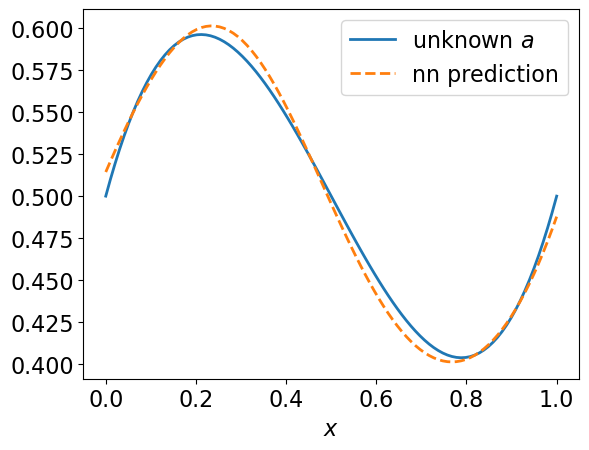

In [18]:
plt.plot(x_test,a_exact,
         linewidth=2.0,
         label=r'unknown $a$')
plt.plot(x_test,a_pred,
         label='nn prediction',
         linewidth=2.0,
         linestyle='--')
#plt.ylabel(r'$u(x)$',fontsize=16) # "r" means raw sequence
plt.yticks(fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16)
plt.savefig('Images/results_2.png', dpi=300, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, 
            bbox_inches='tight', pad_inches=0.1, metadata=None)